# Sesión 07 - Manejo de Modelos de Clasificación para entornos operativos

*Objetivo*

- Aplicar algoritmos de clasificación para identificar eventos operacionales críticos en la industria petrolera.
- Evaluar el rendimiento de diferentes clasificadores.
- Interpretar los resultados y la matriz de confusión.
- Analizar la eficiencia en pozos productores.

In [1]:
!python --version


Python 3.12.1


## 0. Carga de Librerías

In [2]:
# Instalación de dependencias del nuevo codespace
!pip install -r ../requirements.txt


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
# Importación de Librerías
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Modelamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix # Modelos de Clasificación
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_squared_error # Modelos de Regresión

## 1. Carga de Datos

In [4]:
# Carga desde la carpeta data/raw/

# Ruta Absoluta en Linux o Mac
df = pd.read_csv("/workspaces/ml-bootcamp-labs/data/raw/Operational_events.csv")


In [5]:
df

Well_ID        Date      Time     Pressure  Temperature   Flow_Rate  \
0        7.0  2023-12-15  14:42:07  3394.633937   131.203728  155.994520   
1        2.0  2023-12-10  11:29:37  1003.115063   298.442312  617.481510   
2       16.0  2023-09-28  14:50:43  3056.937754   218.482914   46.450413   
3        9.0  2023-12-12  20:01:19  1964.101864   236.652704  609.996658   
4        6.0  2023-02-23  09:03:53  1125.253170   268.456955  449.754133   
..       ...         ...       ...          ...          ...         ...   
495      2.0  2023-11-10  17:22:01  1224.855622   249.504127  850.852757   
496      9.0  2023-09-16  13:54:10  1870.915599   224.245306   48.078968   
497      8.0  2023-01-16  16:50:53  4580.306237   214.785827  350.777623   
498     11.0  2023-04-13  08:41:49  3258.376325   150.464549  915.289940   
499      4.0  2023-10-03  17:52:35  1760.911723   204.177157  469.059744   

      Pump_Speed  Gas_Oil_Ratio  Water_Cut  Vibration Event_Type  \
0     174.250837    1326.028990   0.601115   7.080726     Normal   
1    1834.959481            NaN   0.023062   5.247747     Normal   
2    1822.634556     421.681361        NaN   9.488855   Blockage   
3    2499.584735     425.374050   0.391061   1.822361     Normal   
4    1185.450708    1404.656526   0.727272   3.265408     Normal   
..           ...            ...        ...        ...        ...   
495   858.405127    1032.581456   0.314162   9.579711     Normal   
496  1450.723757     219.041265   0.921144   9.760860     Normal   
497  2498.081239     841.428711   0.911633   9.280142     Normal   
498   797.056695    1364.560451        NaN   6.565627   Blockage   
499          NaN    1263.800163   0.335682   5.745822     Normal   

     Maintenance_Required   Downtime  
0                     0.0   0.000000  
1                     0.0   0.000000  
2                     1.0  59.737430  
3                     0.0   0.000000  
4                     0.0   0.000000  
..                    ...        ...  
495                   0.0   0.000000  
496                   0.0   0.000000  
497                   0.0   0.000000  
498                   1.0  18.799964  
499                   0.0   0.000000  

[500 rows x 13 columns]

## 2. EDA (Medidas de Tendencia Central, Análisis de Nulos)

In [6]:
# Métodos info(), describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Well_ID               475 non-null    float64
 1   Date                  475 non-null    object 
 2   Time                  475 non-null    object 
 3   Pressure              475 non-null    float64
 4   Temperature           475 non-null    float64
 5   Flow_Rate             475 non-null    float64
 6   Pump_Speed            475 non-null    float64
 7   Gas_Oil_Ratio         475 non-null    float64
 8   Water_Cut             475 non-null    float64
 9   Vibration             475 non-null    float64
 10  Event_Type            500 non-null    object 
 11  Maintenance_Required  475 non-null    float64
 12  Downtime              475 non-null    float64
dtypes: float64(10), object(3)
memory usage: 50.9+ KB


In [7]:
df.describe()

Well_ID     Pressure  Temperature   Flow_Rate   Pump_Speed  \
count  475.000000   475.000000   475.000000  475.000000   475.000000   
mean    10.362105  2960.284279   202.865593  490.951223  1474.688338   
std      5.803338  1169.230972    56.146715  285.666948   855.630251   
min      1.000000  1001.771126   100.270725    0.011635     3.088440   
25%      5.000000  1920.023988   153.730480  253.453970   692.447336   
50%     10.000000  3021.461026   204.310197  486.173654  1537.964259   
75%     15.000000  3966.937400   251.558604  729.514778  2177.116863   
max     20.000000  4990.997556   299.361836  995.734452  2999.141412   

       Gas_Oil_Ratio   Water_Cut   Vibration  Maintenance_Required    Downtime  
count     475.000000  475.000000  475.000000            475.000000  475.000000  
mean      826.067573    0.517296    4.767155              0.193684    9.716888  
std       371.162601    0.293007    2.825830              0.395601   25.604104  
min       204.183743    0.001992    0.031409              0.000000    0.000000  
25%       496.807440    0.275245    2.228550              0.000000    0.000000  
50%       825.174981    0.519032    4.809060              0.000000    0.000000  
75%      1136.238405    0.756875    7.076513              0.000000    0.000000  
max      1495.535353    0.997518    9.966969              1.000000  152.279829

In [8]:
df.loc[ df.Date.isnull()  ]

Well_ID Date      Time     Pressure  Temperature   Flow_Rate  \
17       9.0  NaN  02:18:47  4386.644569          NaN  404.508127   
69       4.0  NaN  23:36:07  3605.468844   254.249334  374.435370   
70       5.0  NaN  13:35:53  4349.963156   166.429283  311.444264   
75       1.0  NaN  22:38:02  2493.237265   154.148935  643.999543   
98      18.0  NaN  15:12:27  1304.523438   270.241383  495.146527   
127      9.0  NaN  08:24:47  4009.711050   118.096339  288.685596   
149     11.0  NaN  01:59:22  1608.099413   112.269925  780.761586   
158      8.0  NaN  09:37:46  1328.686670          NaN  295.444777   
163     15.0  NaN  17:30:14  3023.410772   268.140606         NaN   
194     15.0  NaN  05:52:35          NaN   148.378766   12.404036   
268     10.0  NaN  00:31:47  3334.227869   205.151244  249.524367   
276     13.0  NaN  21:06:42  2964.382918   285.422126  105.393218   
312     10.0  NaN  14:54:38  3250.220805   253.032066  940.419207   
332     15.0  NaN  22:30:51  1109.000048   204.717297  218.259873   
335      2.0  NaN  14:04:25  2630.992420   132.243762  656.409604   
336     15.0  NaN  10:46:43  3773.340615   229.647179  231.480096   
374     18.0  NaN  19:32:00  1650.151950   235.124262   38.086301   
376      4.0  NaN  06:47:45  4020.534470   217.324784  828.438671   
380      2.0  NaN  23:21:01  4303.729234   226.291759  784.405473   
395      1.0  NaN  12:48:59  1486.781227   217.618728  316.077684   
400     20.0  NaN  01:53:55  4726.791895   224.074250  803.755236   
451     17.0  NaN  06:39:12  1521.412520   140.706975  769.061133   
453     13.0  NaN  13:10:41  2714.577117   225.700434  215.155622   
477      6.0  NaN  23:58:34  4200.550331   148.331784         NaN   
491      6.0  NaN  07:50:53  4282.030017   252.006980   48.766319   

      Pump_Speed  Gas_Oil_Ratio  Water_Cut  Vibration    Event_Type  \
17   2663.310296    1306.206983   0.935635   7.853407        Normal   
69    206.764618     300.517385   0.104247   8.404396      Blockage   
70    682.186863     990.262712   0.379306   7.442497        Normal   
75   1226.202513     233.002262   0.156153   7.159722        Normal   
98   1441.759732     970.130120   0.824681   3.478092        Normal   
127   327.328895    1045.665142   0.765191   9.256748        Normal   
149  1379.401271     275.612934   0.994866   0.577806        Normal   
158  2307.669444    1012.062640   0.381940   2.056873        Normal   
163  1626.711616     967.451998   0.508361   2.975485        Normal   
194  1406.303896     591.644839   0.598357   2.972378        Normal   
268     6.055553     426.306178   0.117066   4.490847        Normal   
276  2293.322184     732.572369   0.655174   2.602366        Normal   
312    47.469516     879.588184   0.470867   6.560550        Normal   
332  2968.295297     946.767783   0.137885   6.887625  Pump Failure   
335  2913.452722            NaN   0.714753   0.684505        Normal   
336  2044.059040    1422.238149   0.046786   3.196521        Normal   
374  1859.905695    1107.657960        NaN   0.419641        Normal   
376   240.560270     819.890541   0.630093   8.286529        Normal   
380  1795.688980     738.383389   0.957946   5.411138        Normal   
395  1880.905304    1250.913347   0.611646   2.957476        Normal   
400   251.174814     701.721364   0.373947   8.862882        Normal   
451  1276.516978     935.040722   0.021009   0.344313        Normal   
453  1882.403696    1400.764289   0.997518   0.324511        Normal   
477   950.712413     546.832914   0.505926   7.777279  Pump Failure   
491  2531.186378     769.457299   0.342395   5.464764        Normal   

     Maintenance_Required    Downtime  
17                    0.0    0.000000  
69                    1.0   15.859890  
70                    0.0    0.000000  
75                    0.0    0.000000  
98                    0.0    0.000000  
127                   0.0    0.000000  
149                   0.0    0.000000  
158                   0.0    0.000000  
163

<Axes: >

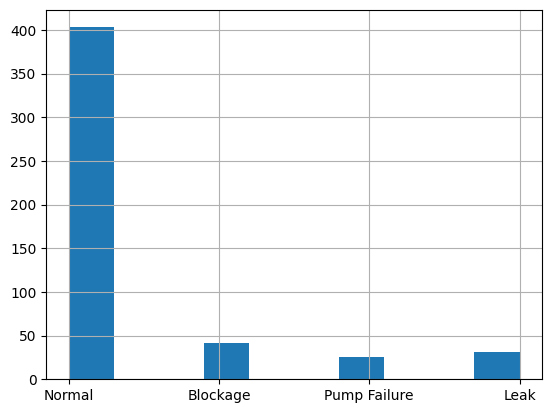

In [9]:
df.Event_Type.hist()

## 3. Transformaciones (Encoding, Imputación)

In [10]:
df.isnull().sum()

Well_ID                 25
Date                    25
Time                    25
Pressure                25
Temperature             25
Flow_Rate               25
Pump_Speed              25
Gas_Oil_Ratio           25
Water_Cut               25
Vibration               25
Event_Type               0
Maintenance_Required    25
Downtime                25
dtype: int64

In [11]:
df.Temperature.describe()

count    475.000000
mean     202.865593
std       56.146715
min      100.270725
25%      153.730480
50%      204.310197
75%      251.558604
max      299.361836
Name: Temperature, dtype: float64

<Axes: >

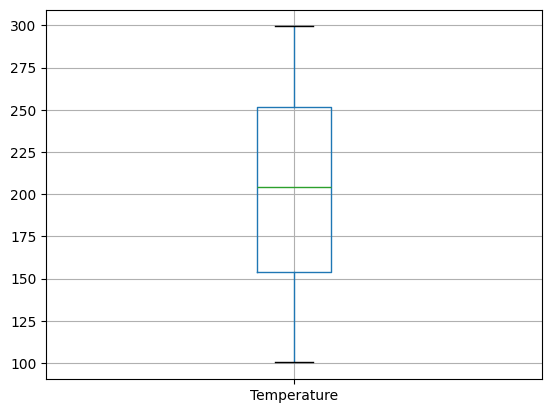

In [12]:
df.Temperature.to_frame().boxplot()

In [13]:
# Método de Imputación "Simple"
# Cuando tenemos pocas variables podemos completar el valor faltante con una medida de tendencia central, como la media
df.Temperature.fillna(df.Temperature.mean())
df.Pressure.fillna(df.Pressure.mean())

0      3394.633937
1      1003.115063
2      3056.937754
3      1964.101864
4      1125.253170
          ...     
495    1224.855622
496    1870.915599
497    4580.306237
498    3258.376325
499    1760.911723
Name: Pressure, Length: 500, dtype: float64

In [14]:
from sklearn.preprocessing import LabelEncoder

In [15]:
label_encoder = LabelEncoder()

# Crear una columna de tipo numérica que va a asignar un número con base a Event_Type
df['Event_Type_n'] = label_encoder.fit_transform(df.Event_Type)

df[["Event_Type_n","Event_Type"]].value_counts()

Event_Type_n  Event_Type  
2             Normal          403
0             Blockage         41
1             Leak             31
3             Pump Failure     25
Name: count, dtype: int64

In [16]:
df.Well_ID.unique()

array([ 7.,  2., 16.,  9.,  6.,  8., 15.,  4., 20., nan, 10.,  3.,  1.,
       17.,  5., 14., 18., 19., 11., 12., 13.])

In [17]:
# Diccionario Manual para hacer la codificacion
manual_encode = {
    "Normal" : 0,
    "Blockage" : 1,
    "Leak" : 2,
    "Pump Failure": 3
}

df.Event_Type.map(manual_encode)

0      0
1      0
2      1
3      0
4      0
      ..
495    0
496    0
497    0
498    1
499    0
Name: Event_Type, Length: 500, dtype: int64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Well_ID               475 non-null    float64
 1   Date                  475 non-null    object 
 2   Time                  475 non-null    object 
 3   Pressure              475 non-null    float64
 4   Temperature           475 non-null    float64
 5   Flow_Rate             475 non-null    float64
 6   Pump_Speed            475 non-null    float64
 7   Gas_Oil_Ratio         475 non-null    float64
 8   Water_Cut             475 non-null    float64
 9   Vibration             475 non-null    float64
 10  Event_Type            500 non-null    object 
 11  Maintenance_Required  475 non-null    float64
 12  Downtime              475 non-null    float64
 13  Event_Type_n          500 non-null    int64  
dtypes: float64(10), int64(1), object(3)
memory usage: 54.8+ KB


In [19]:
# Instrucción para descartar columnas que no sean numéricas
# Y aparte renombra la columna codificada por el nombre original
df_encoded = df.select_dtypes(exclude=['object']).rename(columns={"Event_Type_n":"Event_Type"})

In [20]:
df_encoded

Well_ID     Pressure  Temperature   Flow_Rate   Pump_Speed  \
0        7.0  3394.633937   131.203728  155.994520   174.250837   
1        2.0  1003.115063   298.442312  617.481510  1834.959481   
2       16.0  3056.937754   218.482914   46.450413  1822.634556   
3        9.0  1964.101864   236.652704  609.996658  2499.584735   
4        6.0  1125.253170   268.456955  449.754133  1185.450708   
..       ...          ...          ...         ...          ...   
495      2.0  1224.855622   249.504127  850.852757   858.405127   
496      9.0  1870.915599   224.245306   48.078968  1450.723757   
497      8.0  4580.306237   214.785827  350.777623  2498.081239   
498     11.0  3258.376325   150.464549  915.289940   797.056695   
499      4.0  1760.911723   204.177157  469.059744          NaN   

     Gas_Oil_Ratio  Water_Cut  Vibration  Maintenance_Required   Downtime  \
0      1326.028990   0.601115   7.080726                   0.0   0.000000   
1              NaN   0.023062   5.247747                   0.0   0.000000   
2       421.681361        NaN   9.488855                   1.0  59.737430   
3       425.374050   0.391061   1.822361                   0.0   0.000000   
4      1404.656526   0.727272   3.265408                   0.0   0.000000   
..             ...        ...        ...                   ...        ...   
495    1032.581456   0.314162   9.579711                   0.0   0.000000   
496     219.041265   0.921144   9.760860                   0.0   0.000000   
497     841.428711   0.911633   9.280142                   0.0   0.000000   
498    1364.560451        NaN   6.565627                   1.0  18.799964   
499    1263.800163   0.335682   5.745822                   0.0   0.000000   

     Event_Type  
0             2  
1             2  
2             0  
3             2  
4             2  
..          ...  
495           2  
496           2  
497           2  
498           0  
499           2  

[500 rows x 11 columns]

In [21]:
# Carga de librería de SimpleImputer
from sklearn.impute import SimpleImputer

In [22]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Well_ID               475 non-null    float64
 1   Pressure              475 non-null    float64
 2   Temperature           475 non-null    float64
 3   Flow_Rate             475 non-null    float64
 4   Pump_Speed            475 non-null    float64
 5   Gas_Oil_Ratio         475 non-null    float64
 6   Water_Cut             475 non-null    float64
 7   Vibration             475 non-null    float64
 8   Maintenance_Required  475 non-null    float64
 9   Downtime              475 non-null    float64
 10  Event_Type            500 non-null    int64  
dtypes: float64(10), int64(1)
memory usage: 43.1 KB


In [23]:
imputer = SimpleImputer(strategy="mean")

df_imputado = pd.DataFrame( imputer.fit_transform(df_encoded), columns= df_encoded.columns  )

In [24]:
"""
Event_Type_n  Event_Type  
2             Normal          403
0             Blockage         41
1             Leak             31
3             Pump Failure     25
Name: count, dtype: int64
"""

'\nEvent_Type_n  Event_Type  \n2             Normal          403\n0             Blockage         41\n1             Leak             31\n3             Pump Failure     25\nName: count, dtype: int64\n'

In [25]:
df_imputado

Well_ID     Pressure  Temperature   Flow_Rate   Pump_Speed  \
0        7.0  3394.633937   131.203728  155.994520   174.250837   
1        2.0  1003.115063   298.442312  617.481510  1834.959481   
2       16.0  3056.937754   218.482914   46.450413  1822.634556   
3        9.0  1964.101864   236.652704  609.996658  2499.584735   
4        6.0  1125.253170   268.456955  449.754133  1185.450708   
..       ...          ...          ...         ...          ...   
495      2.0  1224.855622   249.504127  850.852757   858.405127   
496      9.0  1870.915599   224.245306   48.078968  1450.723757   
497      8.0  4580.306237   214.785827  350.777623  2498.081239   
498     11.0  3258.376325   150.464549  915.289940   797.056695   
499      4.0  1760.911723   204.177157  469.059744  1474.688338   

     Gas_Oil_Ratio  Water_Cut  Vibration  Maintenance_Required   Downtime  \
0      1326.028990   0.601115   7.080726                   0.0   0.000000   
1       826.067573   0.023062   5.247747                   0.0   0.000000   
2       421.681361   0.517296   9.488855                   1.0  59.737430   
3       425.374050   0.391061   1.822361                   0.0   0.000000   
4      1404.656526   0.727272   3.265408                   0.0   0.000000   
..             ...        ...        ...                   ...        ...   
495    1032.581456   0.314162   9.579711                   0.0   0.000000   
496     219.041265   0.921144   9.760860                   0.0   0.000000   
497     841.428711   0.911633   9.280142                   0.0   0.000000   
498    1364.560451   0.517296   6.565627                   1.0  18.799964   
499    1263.800163   0.335682   5.745822                   0.0   0.000000   

     Event_Type  
0           2.0  
1           2.0  
2           0.0  
3           2.0  
4           2.0  
..          ...  
495         2.0  
496         2.0  
497         2.0  
498         0.0  
499         2.0  

[500 rows x 11 columns]

In [26]:
df_imputado.Event_Type.value_counts()

Event_Type
2.0    403
0.0     41
1.0     31
3.0     25
Name: count, dtype: int64

In [27]:
# Regla de balanceo de clases
(41+31+25)/3 * 1.1

35.56666666666667

In [28]:
majority_class_df_sample = df_imputado.loc[ df_imputado.Event_Type == 2 ].sample(35)

In [29]:
df_imputado.loc[ df_imputado.Event_Type == 2 ].describe()

Well_ID     Pressure  Temperature   Flow_Rate   Pump_Speed  \
count  403.000000   403.000000   403.000000  403.000000   403.000000   
mean    10.420170  2942.621347   202.557660  488.745052  1501.895679   
std      5.704338  1157.050270    54.862889  277.016238   827.785615   
min      1.000000  1001.771126   101.810832    0.011635     3.088440   
25%      6.000000  1920.023988   158.692183  260.185968   780.150099   
50%     10.362105  2960.284279   202.865593  490.951223  1498.645006   
75%     15.000000  3955.884754   248.920758  699.242711  2172.211041   
max     20.000000  4990.997556   299.361836  995.734452  2999.141412   

       Gas_Oil_Ratio   Water_Cut   Vibration  Maintenance_Required  \
count     403.000000  403.000000  403.000000            403.000000   
mean      831.211214    0.523728    4.662769              0.009612   
std       356.558956    0.283777    2.784483              0.042116   
min       204.183743    0.001992    0.031409              0.000000   
25%       551.626912    0.299550    2.131812              0.000000   
50%       826.067573    0.517296    4.767155              0.000000   
75%      1110.742217    0.752962    6.796059              0.000000   
max      1495.535353    0.997518    9.963343              0.193684   

         Downtime  Event_Type  
count  403.000000       403.0  
mean     0.458116         2.0  
std      2.062073         0.0  
min      0.000000         2.0  
25%      0.000000         2.0  
50%      0.000000         2.0  
75%      0.000000         2.0  
max      9.716888         2.0

In [30]:
majority_class_df_sample.describe()

Well_ID     Pressure  Temperature   Flow_Rate   Pump_Speed  \
count  35.000000    35.000000    35.000000   35.000000    35.000000   
mean    8.696060  2845.104171   196.374733  567.000302  1584.389061   
std     5.637641  1121.082899    55.376289  316.663040   747.986386   
min     1.000000  1088.264595   112.269925   18.006556    15.435512   
25%     4.000000  1734.840864   159.304961  226.468500  1175.591263   
50%     8.000000  2960.284279   195.631785  654.342005  1537.964259   
75%    12.500000  3527.889735   233.845734  836.073385  2033.541720   
max    20.000000  4845.261153   297.684199  977.279933  2888.431071   

       Gas_Oil_Ratio  Water_Cut  Vibration  Maintenance_Required   Downtime  \
count      35.000000  35.000000  35.000000             35.000000  35.000000   
mean      821.762851   0.453742   4.321439              0.011068   0.555251   
std       394.858977   0.271524   2.760275              0.045613   2.288367   
min       209.137965   0.025770   0.031409              0.000000   0.000000   
25%       561.617057   0.232617   1.567422              0.000000   0.000000   
50%       784.154665   0.429623   4.667281              0.000000   0.000000   
75%      1182.070158   0.621178   6.136359              0.000000   0.000000   
max      1487.431995   0.994866   9.087013              0.193684   9.716888   

       Event_Type  
count        35.0  
mean          2.0  
std           0.0  
min           2.0  
25%           2.0  
50%           2.0  
75%           2.0  
max           2.0

In [31]:
majority_class_df_sample

Well_ID     Pressure  Temperature   Flow_Rate   Pump_Speed  \
149  11.000000  1608.099413   112.269925  780.761586  1379.401271   
351  10.362105  4304.258738   234.618426  824.350447  1190.976487   
305  17.000000  4531.659266   231.809082  211.231831  2588.990494   
37   15.000000  3472.872253   120.224535   84.106806  2102.907394   
193  16.000000  4015.847614   202.865593   18.006556  2888.431071   
325   8.000000  1247.233843   118.472106  162.790989  1474.688338   
41    4.000000  3092.391377   225.879728  695.748689  1363.623194   
326  10.000000  1708.770004   158.853347  114.796927  2824.598731   
289  11.000000  2516.906149   266.273541  842.325505  1119.723469   
11   20.000000  3042.989210   183.482201  222.107810   359.596102   
298   3.000000  3264.722765   162.555598  654.342005  1474.688338   
282  10.000000  1230.928637   178.206574  234.203371   658.661770   
484   3.000000  2869.043984   121.342364  649.556007  2603.998776   
190  20.000000  2117.104354   202.865593  694.150574  1537.964259   
362   5.000000  2960.284279   159.756574  891.200073    40.902072   
371  14.000000  3201.887108   258.002968  490.951223  1739.193498   
353   2.000000  3475.088308   233.073042  500.710926  1934.583668   
28   16.000000  3920.157266   202.865593  566.037210   475.939343   
140  12.000000  3371.247967   236.026386  230.829189  1370.575935   
424   1.000000  2910.968506   195.631785  767.969978  1885.699202   
422   7.000000  1777.094284   189.440206  829.821265  1964.176045   
15    4.000000  3580.691162   134.873286  690.937738  1160.206039   
225  13.000000  3591.269784   124.584136  888.659080  1509.251852   
173   5.000000  1199.368111   280.782666  909.390192  2340.639190   
421   1.000000  4278.499478   277.638270  199.219686   852.552887   
310   2.000000  3468.875224   131.196173  478.496116  2341.668081   
373  15.000000  1245.785161   262.744669  940.503953  1946.296158   
499   4.000000  1760.911723   204.177157  469.059744  1474.688338   
5     8.000000  2960.284279   217.350233  965.255307  1821.102743   
352  12.000000  1624.806032   297.684199  977.279933  2381.454312   
408   3.000000  1567.977037   160.848373  139.246845  1836.025590   
443  10.000000  2940.071950   117.080606  972.461390  1554.031294   
342   5.000000  4787.024979   180.042455  783.297983   797.785352   
100   6.000000  4845.261153   193.094002  879.071480    15.435512   
378   1.000000  1088.264595   296.504254   86.132139  2443.160338   

     Gas_Oil_Ratio  Water_Cut  Vibration  Maintenance_Required  Downtime  \
149     275.612934   0.994866   0.577806              0.000000  0.000000   
351     403.212062   0.737951   4.767155              0.000000  0.000000   
305    1351.921466   0.196654   7.374261              0.000000  0.000000   
37      294.591908   0.821860   7.062422              0.000000  0.000000   
193    1144.672290   0.304751   8.293947              0.000000  0.000000   
325     395.613952   0.968076   4.467145              0.000000  0.000000   
41     1015.825504   0.584314   9.011580              0.000000  0.000000   
326    1219.468027   0.462391   8.649626              0.000000  0.000000   
289    1021.585285   0.095372   1.036786              0.000000  0.000000   
11      638.899723   0.942910   3.232029              0.193684  0.000000   
298     826.067573   0.764353   6.237431              0.000000  0.000000   
282    1447.821644   0.616300   5.568784              0.000000  0.000000   
484    1276.641630   0.626055   0.752787              0.000000  0.000000   
190     596.903880   0.212644   0.331894              0.193684  0.000000   
362     826.067573   0.554357   1.482175              0.000000  0.000000   
371     649.312492   0.815769   4.667281              0.000000  0.000000   
353     230.592243   0.429623   4.767155              0.000000  0.000000   
28      356.214042   0.341880   0.917991              0.000000  0.000000   
140     447.422322   0.517296   3.784764              0.000000  0.000000   
42

In [32]:
minority_class_df_sample = df_imputado.loc[ df_imputado.Event_Type != 2]

In [33]:
minority_class_df_sample

Well_ID     Pressure  Temperature   Flow_Rate   Pump_Speed  \
2       16.0  3056.937754   218.482914   46.450413  1822.634556   
8       15.0  1943.939679   151.213665   40.433590  2131.988669   
9        4.0  2641.531692   251.110228  228.798165   230.939729   
19      16.0  3170.160922   202.865593  636.332618   751.385456   
30      10.0  4425.959365   231.738726  162.934427   211.706242   
..       ...          ...          ...         ...          ...   
477      6.0  4200.550331   148.331784  490.951223   950.712413   
481     13.0  1727.054391   200.826568  322.809793   774.322930   
485      7.0  2546.785800   264.228485  969.490899  1361.778409   
489     10.0  3861.289242   153.628646  315.668481   375.753693   
498     11.0  3258.376325   150.464549  915.289940   797.056695   

     Gas_Oil_Ratio  Water_Cut  Vibration  Maintenance_Required    Downtime  \
2       421.681361   0.517296   9.488855                   1.0   59.737430   
8       344.158067   0.439337   2.017192                   1.0   92.453312   
9       576.676889   0.161221   9.296977                   1.0   31.869765   
19      966.832102   0.978893   4.867422                   1.0   35.801239   
30     1035.145062   0.026511   5.857756                   1.0   44.830347   
..             ...        ...        ...                   ...         ...   
477     546.832914   0.505926   7.777279                   1.0  145.660428   
481     803.181043   0.133284   9.277457                   1.0  125.897364   
485     859.099506   0.572172   9.323481                   1.0   48.566562   
489    1052.162963   0.039797   5.976823                   1.0  152.279829   
498    1364.560451   0.517296   6.565627                   1.0   18.799964   

     Event_Type  
2           0.0  
8           3.0  
9           1.0  
19          0.0  
30          0.0  
..          ...  
477         3.0  
481         3.0  
485         3.0  
489         3.0  
498         0.0  

[97 rows x 11 columns]

In [34]:
df_balanced = pd.concat([ majority_class_df_sample, minority_class_df_sample])

In [35]:
df_balanced.Event_Type.value_counts()

Event_Type
0.0    41
2.0    35
1.0    31
3.0    25
Name: count, dtype: int64

## 4. Modelamiento

In [36]:
# Carga de librerías para modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


In [37]:
X = df_balanced.drop(columns=["Event_Type"])
y = df_balanced.Event_Type
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size= 0.8, random_state=23)

In [38]:
model_dtc = DecisionTreeClassifier()
model_dtc.fit(X_train,y_train)

DecisionTreeClassifier()

In [39]:
model_knc = KNeighborsClassifier()
model_knc.fit(X_train,y_train)

KNeighborsClassifier()

In [40]:
model_svc = SVC()
model_svc.fit(X_train,y_train)

SVC()

## 5. Evaluación

In [41]:
predict_dtc = model_dtc.predict(X_test)
predict_knc = model_knc.predict(X_test)
predict_svc = model_svc.predict(X_test)

In [42]:
X_test.Maintenance_Required.value_counts()

Maintenance_Required
1.000000    16
0.000000    10
0.193684     1
Name: count, dtype: int64

In [43]:
# Evaluación DTC
dtc_accuracy = accuracy_score(y_pred= predict_dtc, y_true= y_test) 
dtc_precision = precision_score(y_pred= predict_dtc, y_true= y_test,average='weighted')
dtc_recall = recall_score(y_pred= predict_dtc, y_true= y_test,average='weighted')
dtc_f1 = f1_score(y_pred= predict_dtc, y_true= y_test,average='weighted')
dtc_cmatrix = confusion_matrix(y_pred= predict_dtc, y_true= y_test)

In [44]:
print(dtc_accuracy)
print(dtc_precision)
print(dtc_recall)
print(dtc_f1)

0.6296296296296297
0.8271604938271605
0.6296296296296297
0.6256728778467909


In [45]:
dtc_cmatrix

array([[ 3,  3,  0,  5],
       [ 0,  1,  1,  1],
       [ 0,  0, 11,  0],
       [ 0,  0,  0,  2]])

In [46]:
dtc_cmatrix

array([[ 3,  3,  0,  5],
       [ 0,  1,  1,  1],
       [ 0,  0, 11,  0],
       [ 0,  0,  0,  2]])

In [47]:
confusion_matrix(y_pred= predict_knc, y_true= y_test)

array([[4, 2, 4, 1],
       [1, 2, 0, 0],
       [2, 4, 3, 2],
       [1, 0, 1, 0]])

In [48]:
confusion_matrix(y_pred= predict_svc, y_true= y_test)

array([[3, 3, 2, 3],
       [0, 3, 0, 0],
       [5, 3, 0, 3],
       [1, 1, 0, 0]])

In [49]:
# Objeto donde nosotros tenemos el modelo:
model_dtc

DecisionTreeClassifier()

## Sesión 09. Exportación del Modelo

In [50]:
# Importación de Librería
import pickle

In [51]:
open('archivo_de_prueba.txt','wb')

<_io.BufferedWriter name='archivo_de_prueba.txt'>

In [52]:
# Ejemplo de exportación de objetos en python
arreglo_ejemplo = np.array([0.2,0.3,0.5])
with open('archivo.pkl','wb') as archivo_destino:
    pickle.dump(arreglo_ejemplo,archivo_destino)

In [53]:
# Exportación del modelo 'model_dtc'
# Guardado en la carpeta 'models/'
# Archivo de guardado se llama 'model_op.pkl'

with open('/workspaces/ml-bootcamp-labs/models/model_op.pkl','wb') as file:
    pickle.dump(model_dtc,file)